In [101]:
import os
import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import nltk.translate.bleu_score as bleu
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import torch
import tensorflow as tf
import torchvision.models as models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU, Layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [3]:
REPORTS_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/IU X-Ray New/ecgen-radiology'
IMAGES_DIR_PATH = '/content/drive/My Drive/Colab Notebooks/Data/IUXRay/Scanned Images Unzipped/Scanned Images/'
GLOVE_FILE_PATH = 'drive/My Drive/Colab Notebooks/Data/IUXRay/' + 'glove.42B.300d.txt'

In [4]:
impressions, images = [], []

for report_name in sorted(os.listdir(REPORTS_PATH)):
    root = ET.parse(os.path.join(REPORTS_PATH, report_name)).getroot()
    image_id = []

    for child in root.iter():
        if child.tag == 'AbstractText':
            if child.attrib['Label'] == 'IMPRESSION':
                impressions.append(child.text)
        if child.tag == 'parentImage':
            image_id.append(IMAGES_DIR_PATH + child.attrib['id']+'.png')
    images.append(image_id)

In [5]:
data_df = pd.DataFrame(
    {'images': images,
     'impressions': impressions
    })

In [6]:
data_df = data_df[data_df['images'].apply(len) > 0]
data_df['images'] = data_df['images'].apply(lambda x: x[:2] if len(x) >= 2 else [x[0], x[0]])
data_df.reset_index(drop=True, inplace=True)

In [7]:
data_df.isna().sum()

images          0
impressions    31
dtype: int64

In [8]:
data_df.dropna(inplace=True)

In [9]:
contraction_mapping = {
    "won't": "will not",
    "can't": "can not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def preprocess_text(text):
    text = re.sub('XXXX|xxxx', '', text)
    text = re.sub(r'[^A-Za-z.]+', ' ', text) # removing periods too because impressions are one line
    for contraction, expansion in contraction_mapping.items():
      text = re.sub(r'%s' %contraction, expansion, text)
    text = re.sub(r'[\r\n]', ' ', text)
    text = text.lstrip('. ')
    text = re.sub(r'\s*\.{2,}\s*$', '', text)
    return text

In [10]:
data_df['impressions'].head()

0                                 Normal chest x-XXXX.
1                    No acute cardiopulmonary process.
2                                   No active disease.
3    1. Increased opacity in the right upper lobe w...
4    Diffuse fibrosis. No visible focal acute disease.
Name: impressions, dtype: object

In [11]:
data_df['impressions'] = data_df['impressions'].apply(lambda x: preprocess_text(x))
data_df.reset_index(inplace=True)

In [12]:
data_df['impressions'].head()

0                                     Normal chest x .
1                    No acute cardiopulmonary process.
2                                   No active disease.
3    Increased opacity in the right upper lobe with...
4    Diffuse fibrosis. No visible focal acute disease.
Name: impressions, dtype: object

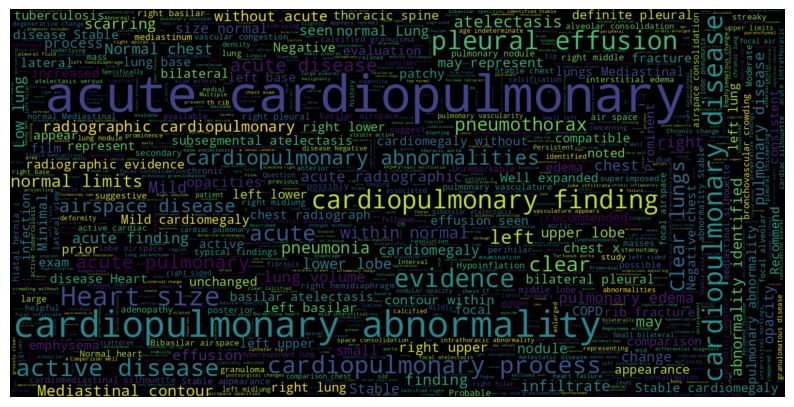

In [13]:
wc = WordCloud(background_color="black",
               max_words=len(data_df),
               width=1600,
               height=800)
wc.generate(' '.join(data_df["impressions"]))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
print("The top 20 most occuring impressions:\n")
data_df.impressions.value_counts(dropna = False)[:20]

The top 20 most occuring impressions:



No acute cardiopulmonary abnormality.             320
No active disease.                                130
No acute cardiopulmonary findings.                126
No acute cardiopulmonary disease.                 123
No acute cardiopulmonary abnormalities.           122
No acute disease.                                 109
No evidence of active disease.                     91
No acute radiographic cardiopulmonary process.     78
No acute cardiopulmonary process.                  72
No acute pulmonary disease.                        58
No acute cardiopulmonary abnormality. .            47
No acute cardiopulmonary abnormality               44
No acute cardiopulmonary findings. .               36
Normal chest                                       36
No acute findings                                  30
Negative for acute abnormality.                    30
No acute cardiopulmonary finding.                  29
No acute findings.                                 29
No acute pulmonary abnormali

In [15]:
len(data_df)

3820

In [16]:
impression_inputs = []
impression_outputs = []
for i in range(len(data_df)):
    data_df['impressions'][i] =  '<start> ' + data_df['impressions'][i] + ' <end>'
    words = data_df['impressions'][i].split()
    impression_inputs.append(' '.join(words[:-1]))
    impression_outputs.append(' '.join(words[1:]))

In [17]:
print('Sample Report\n')
print('Original:  ', data_df['impressions'][1])
print('Input sequence:  ', impression_inputs[1])
print('Output sequence:  ', impression_outputs[1])

Sample Report

Original:   <start> No acute cardiopulmonary process. <end>
Input sequence:   <start> No acute cardiopulmonary process.
Output sequence:   No acute cardiopulmonary process. <end>


In [18]:
impression_lengths = [len(impression.split()) for impression in data_df['impressions']]
max_length = int(np.percentile(impression_lengths, 100))
print("Maximum length of an impression: ", max_length)

Maximum length of an impression:  125


In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ',lower=True, filters='')
tokenizer.fit_on_texts(data_df['impressions'])

target_vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", target_vocab_size)

target_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(impression_inputs), maxlen=max_length, padding='post')
target_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(impression_outputs), maxlen=max_length, padding='post')

Vocabulary size:  1846


In [20]:
glove_vectors = {}
with open(GLOVE_FILE_PATH, 'r', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [31]:
next(iter(glove_vectors.values())).shape[0]

300

In [40]:
embedding_matrix = np.zeros((target_vocab_size, next(iter(glove_vectors.values())).shape[0]))
for word, index in tokenizer.word_index.items():
    vector = glove_vectors.get(word, None)
    if vector is not None:
        embedding_matrix[index] = vector

In [41]:
img_train, img_val, target_inputs_train, target_inputs_val, target_outputs_train, target_outputs_val = train_test_split(data_df['images'].values,
                                                                                                                        target_inputs,
                                                                                                                        target_outputs,
                                                                                                                        test_size=0.10,
                                                                                                                        random_state=0,
                                                                                                                        shuffle=True)


In [44]:
print(img_train.shape, target_inputs_train.shape ,target_outputs_train.shape)
print(img_val.shape, target_inputs_val.shape, target_outputs_val.shape)

(3438,) (3438, 125) (3438, 125)
(382,) (382, 125) (382, 125)


In [70]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 7
NUM_EPOCHS = 40
learning_rate = 0.00001

embedding_dim = 300
attention_units = 512
dropout_rate = 0.1
input_len_dec = max_length
attention_features_shape = 49

In [47]:
def load_image(path, training=True):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.keras.applications.densenet.preprocess_input(image)
    return image, path

In [48]:
class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, images, cap_input, cap_output, batch_size=1, shuffle=False):
        self.images = images
        self.caption_input = cap_input
        self.caption_output = cap_output
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(images))

    def __getitem__(self, batch_num):
        # returns one batch of data
        start = self.batch_size * batch_num
        stop = self.batch_size * (batch_num+1)
        batch_images1, batch_images2, batch_caption_input, batch_caption_output = [], [], [], []
        for i in range(start, stop):
            image1, image2 = self.__data_generation(self.images[i])
            batch_images1.append(image1)
            batch_images2.append(image2)
            batch_caption_input.append(self.caption_input[i])
            batch_caption_output.append(self.caption_output[i])
        return (tf.convert_to_tensor(batch_images1), tf.convert_to_tensor(batch_images2),
                tf.convert_to_tensor(batch_caption_input)), (tf.convert_to_tensor(batch_caption_output))

    def __len__(self):
        # returns number of batches i.e., size of dataloader
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        # shuffles indices after each epoch, invoked at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, images):
        # loads and preprocesses images
        image1, path1 = load_image(images[0])
        image2, path2 = load_image(images[1])
        return image1, image2

In [49]:
train_dataloader = Dataloder(img_train,
                             target_inputs_train,
                             target_outputs_train,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
val_dataloader = Dataloder(img_val,
                           target_inputs_val,
                           target_outputs_val,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

In [53]:
pretrained_model = tf.keras.applications.DenseNet121(weights='/content/drive/My Drive/Colab Notebooks/Data/IUXRay/CheXNet_weights.h5',
                                                     classes = 14,
                                                     input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

image_feature_extractor = tf.keras.Model(
    inputs=pretrained_model.input,
    outputs=pretrained_model.layers[-3].output
)

In [54]:
image_feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [56]:
class CNN_Encoder(Layer):
    def __init__(self, embedding_dim, feature_extracter):
        super(CNN_Encoder, self).__init__()
        self.image_feature_extractor = feature_extracter

    def call(self, x):
        x = self.image_feature_extractor(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        return x

In [57]:
class AttentionConcat(Layer):
    def __init__(self):
        super().__init__()
        self.W1 = Dense(attention_units)
        self.W2 = Dense(attention_units)
        self.V = Dense(1)

    def call(self, decoder_hidden_state, encoder_output_states):
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        similarities = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output_states)))
        attention_weights = tf.nn.softmax(similarities, axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_output_states, axis=1)
        return context_vector, attention_weights

In [58]:
class Decoder(Model):
    def __init__(self,vocab_size, embedding_dim, input_length, dec_units, atten_layer):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.dense= Dense(self.vocab_size)
        self.attention= atten_layer
        self.embedding = Embedding(
            input_dim = self.vocab_size,
            output_dim =self.embedding_dim,
            weights = [embedding_matrix],
            input_length = self.input_length,
            name = 'decoder_embedding_layer',
            mask_zero=True
            )
        self.lstm = LSTM(
            units = self.dec_units,
            return_state = True,
            return_sequences = True,
            name = 'train_decoder_LSTM',
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
            )

    @tf.function
    def one_step_decoder(self, input_to_decoder, decoder_hidden_state, encoder_output_states, decoder_cell_state):
        embedding = self.embedding(input_to_decoder)
        attention_context, attention_weights = self.attention(decoder_hidden_state, encoder_output_states)
        attention_context = tf.expand_dims(attention_context, 1)
        concat = Concatenate(axis=-1)([embedding, attention_context])
        concat = tf.nn.dropout(concat, dropout_rate)
        decoder_outputs, decoder_hidden_state, decoder_cell_state = self.lstm(concat, initial_state=[decoder_hidden_state, decoder_cell_state])
        decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
        output = self.dense(decoder_outputs)
        return output, decoder_hidden_state, attention_weights, decoder_cell_state

    def reset_hidden_state(self, batch_size):
        return tf.random.normal((batch_size, self.dec_units))

    def reset_cell_state(self, batch_size):
        return tf.random.normal((batch_size,self.dec_units))

    def call(self, input_to_decoder, decoder_hidden_state, encoder_output_states, decoder_cell_state):
        all_outputs = tf.TensorArray(tf.float32, size = input_to_decoder.shape[1], name = "output_arrays")
        for timestep in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, attn_weights, decoder_cell_state = self.one_step_decoder(input_to_decoder[:, timestep:timestep+1],
                                                                                                   decoder_hidden_state,
                                                                                                   encoder_output_states,
                                                                                                   decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

def loss_function(targets, logits):
    crossentropy = SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [60]:
len(train_dataloader), len(val_dataloader)

(491, 54)

In [64]:
steps_per_epoch_train = len(train_dataloader)//BATCH_SIZE
steps_per_epoch_val = len(val_dataloader)//BATCH_SIZE
steps_per_epoch_train, steps_per_epoch_val

(70, 7)

In [65]:
CNN_Encoder = CNN_Encoder(embedding_dim, image_feature_extractor)
decoder = Decoder(target_vocab_size, embedding_dim, input_len_dec, attention_units, AttentionConcat())

In [73]:
!rm -rf -r './checkpoint'

In [74]:
checkpoint_path = "./checkpoint"
ckpt = tf.train.Checkpoint(encoder=CNN_Encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [75]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  print(start_epoch)
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [66]:
train_loss_plot = []
val_loss_plot = []

In [67]:
@tf.function
def train_step(inputs, target):
        loss = 0
        image1, image2, input_text = inputs[0], inputs[1], inputs[2]
        hidden = decoder.reset_hidden_state(batch_size=BATCH_SIZE)
        cell_state = decoder.reset_cell_state(batch_size=BATCH_SIZE)

        with tf.GradientTape() as tape:
            encoder_output = tf.keras.layers.Concatenate(axis=-1)([CNN_Encoder(image1), CNN_Encoder(image2)])
            encoder_output = Dropout(dropout_rate)(encoder_output)
            decoder_output = decoder(input_text,hidden,encoder_output,cell_state)
            loss = tf.reduce_sum([loss_function(target[:, i], decoder_output[:, i]) for i in range(decoder_output.shape[1])])

        total_loss = loss / int(decoder_output.shape[1])
        trainable_variables = CNN_Encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return total_loss

In [69]:
@tf.function
def validation_step(inputs, target):
        loss = 0
        image1, image2, input_text = inputs[0], inputs[1], inputs[2]

        hidden = decoder.reset_hidden_state(batch_size=BATCH_SIZE)
        cell_state = decoder.reset_cell_state(batch_size=BATCH_SIZE)

        encoder_output_1 = CNN_Encoder(image1)
        encoder_output_2 = CNN_Encoder(image2)
        encoder_output = tf.keras.layers.Concatenate(axis=-1)([encoder_output_1, encoder_output_2])

        decoder_output = decoder(input_text, hidden,encoder_output, cell_state)
        loss = tf.reduce_sum([loss_function(target[:, i], decoder_output[:, i]) for i in range(decoder_output.shape[1])])

        total_loss = loss / int(target.shape[1])
        return total_loss

In [ ]:
for epoch in range(start_epoch, NUM_EPOCHS):
    start = time.time()
    total_loss_train = 0
    total_loss_val = 0

    for (batch, (inputs, target)) in (enumerate(train_dataloader)):
        t_loss = train_step(inputs, target)
        total_loss_train += t_loss

        if batch % int(steps_per_epoch_train / 3) == 0:
            print('Epoch {} batch {} loss {:.4f}'.format(epoch+1,batch,t_loss.numpy()))
        if batch >= steps_per_epoch_train:
            break

    for (batch, (inputs, target)) in (enumerate(val_dataloader)):
        t_loss = validation_step(inputs, target)
        total_loss_val += t_loss

        if batch >= steps_per_epoch_val:
            break

    train_loss_plot.append((total_loss_train/steps_per_epoch_train).numpy())
    val_loss_plot.append((total_loss_val/steps_per_epoch_val).numpy())

    ckpt_manager.save()

    train_dataloader.on_epoch_end()
    val_dataloader.on_epoch_end()

    print ('Epoch {} Loss {:.6f} val_loss {:.6f}'.format(epoch + 1,
                                                        total_loss_train / steps_per_epoch_train,
                                                        total_loss_val / steps_per_epoch_val))
    print ('Time taken for 1 epoch: {} seconds\n'.format(time.time() - start))

    if (len(val_loss_plot) > 3) and (val_loss_plot[-1] > np.asarray(val_loss_plot[-3])):
        new_learning_rate = 0.1 * optimizer.lr.numpy()
        print('decreasing learning rate from {:.7f} to {:.7f} :'.format(optimizer.lr.numpy(), new_learning_rate))
        optimizer.lr.assign(new_learning_rate)

    if (len(val_loss_plot) > 6) and (val_loss_plot[-1] > np.asarray(val_loss_plot[-6])):
        print('stopping due to no change in validation loss')
        break

Epoch 1 batch 0 loss 0.4468
Epoch 1 batch 23 loss 0.8364
Epoch 1 batch 46 loss 0.5241
Epoch 1 batch 69 loss 0.6863
Epoch 1 Loss 0.661995 val_loss 0.706313
Time taken for 1 epoch: 1077.920456647873 seconds

Epoch 2 batch 0 loss 0.3971
Epoch 2 batch 23 loss 0.7751
Epoch 2 batch 46 loss 0.4759
Epoch 2 batch 69 loss 0.6372
Epoch 2 Loss 0.609936 val_loss 0.653076
Time taken for 1 epoch: 64.59682369232178 seconds

Epoch 3 batch 0 loss 0.3526
Epoch 3 batch 23 loss 0.7250
Epoch 3 batch 46 loss 0.4408
Epoch 3 batch 69 loss 0.5992
Epoch 3 Loss 0.568329 val_loss 0.617050
Time taken for 1 epoch: 66.8485815525055 seconds

Epoch 4 batch 0 loss 0.3222
Epoch 4 batch 23 loss 0.6932
Epoch 4 batch 46 loss 0.4198
Epoch 4 batch 69 loss 0.5771
Epoch 4 Loss 0.540792 val_loss 0.594546
Time taken for 1 epoch: 64.60843062400818 seconds

Epoch 5 batch 0 loss 0.3026
Epoch 5 batch 23 loss 0.6718
Epoch 5 batch 46 loss 0.4031
Epoch 5 batch 69 loss 0.5586
Epoch 5 Loss 0.521751 val_loss 0.577415
Time taken for 1 epoch

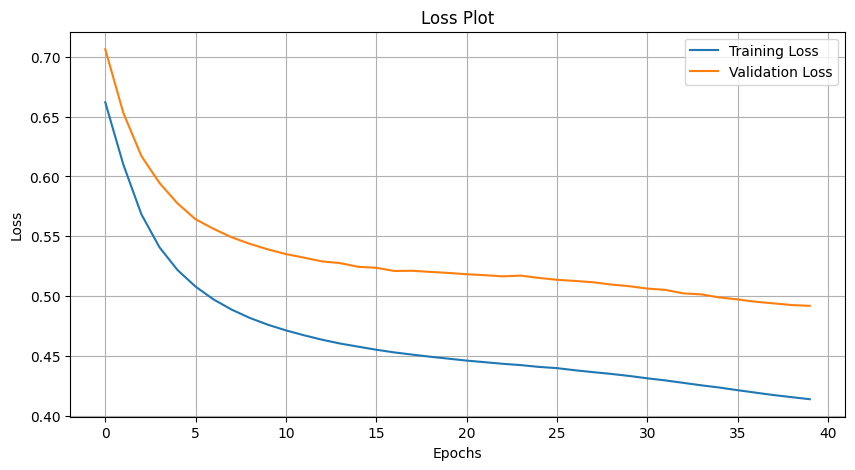

In [78]:
plt.figure(figsize = (10,5))
plt.plot(train_loss_plot, label= 'Training Loss')
plt.plot(val_loss_plot, label = 'Validation Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [92]:
def evaluate(images,capin):
    attention_plot = np.zeros((input_len_dec, attention_features_shape))

    encoder_output_1 = CNN_Encoder(images[0])
    encoder_output_2 = CNN_Encoder(images[1])
    encoder_outputs = tf.keras.layers.Concatenate(axis=-1)([encoder_output_1, encoder_output_2])

    hidden = decoder.reset_hidden_state(batch_size=1)
    cell_state = decoder.reset_cell_state(batch_size=1)
    decoder_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(input_len_dec):
        predictions, hidden, attention_weights, cell_state = decoder.one_step_decoder(decoder_input, hidden, encoder_outputs, cell_state)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [81]:
def clean_sentence(sentence):
    clean = ' '.join(word for word in sentence.split() if word not in ["<start>", "<end>"])
    return clean.strip()

In [89]:
#https://stackoverflow.com/questions/38025838/normalizing-images-in-opencv
def preprocess_img(image_path, training=True):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_NEAREST)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return image, image_path

In [85]:
def load_img(images):
    image1, path1 = preprocess_img(images[0], training = False)
    image2, path2 = preprocess_img(images[1], training = False)
    image1 = tf.expand_dims(image1, axis=0)
    image2 = tf.expand_dims(image2, axis=0)
    return (image1, image2)

In [122]:
def calculate_bleu_scores(sentence, result):
    reference = clean_sentence(sentence)
    translation = clean_sentence(result)

    weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
    bleu_scores = [bleu.sentence_bleu([reference.split()], translation.split(), weights=weight) for weight in weights]

    return tuple(bleu_scores)

def calculate_bleu_for_image(image, sentence_in):
    result, _ = evaluate(image,sentence_in)
    rc = []
    for i in sentence_in.numpy()[0]:
        if tokenizer.index_word[i] == '<end>':
            break
        else:
            rc.append(tokenizer.index_word[i])
    score = calculate_bleu_scores(' '.join(rc), ' '.join(result))
    return score

In [123]:
evaluate_dataloader = Dataloder(data_df['images'].values[:1000], target_inputs[:1000], target_outputs[:1000], batch_size=1, shuffle=False)

In [124]:
bleu1_final = 0
bleu2_final = 0
bleu3_final = 0
bleu4_final = 0

for (batch,(inputs,target)) in tqdm(enumerate(evaluate_dataloader)):
  bleu1, bleu2, bleu3, bleu4 = calculate_bleu_for_image(inputs, target)
  bleu1_final += bleu1
  bleu2_final += bleu2
  bleu3_final += bleu3
  bleu4_final += bleu4

1000it [08:31,  1.96it/s]


In [125]:
print('BLEU1 score', bleu1_final / len(evaluate_dataloader))
print('BLEU2 score', bleu2_final / len(evaluate_dataloader))
print('BLEU3 score', bleu3_final / len(evaluate_dataloader))
print('BLEU4 score', bleu4_final / len(evaluate_dataloader))

BLEU1 score 0.10093663617676751
BLEU2 score 0.02072906957659839
BLEU3 score 0.0016006467367575326
BLEU4 score 2.2032317777037976e-80
